In [103]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy

hrv_middle_data_path = 'hrv-middle-data/'
measurement = 'RMSSD_diff'
test_output_path = 'hrv-middle-data-test/'

res = pd.DataFrame([], columns=['pcode', 'RMSSD_diff', 'CVSD_diff', 'SDNN_diff', 'RMSSD_diff_std', 'CVSD_diff_std', 'SDNN_diff_std'])

for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = hrv_middle_data_path + participant_key + '_hrv_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist!')
        continue

    df = pd.read_csv(file_path)
    
    # if len(df) < 10:
    #     print(file_path + ' has too less data!')
    #     continue

    df['RMSSD_diff'] = df['HRV_RMSSD_after'] - df['HRV_RMSSD_before']
    df['CVSD_diff'] = df['HRV_CVSD_after'] - df['HRV_CVSD_before']
    df['SDNN_diff'] = df['HRV_SDNN_after'] - df['HRV_SDNN_before']
    
    
    df[['RMSSD_diff', 'CVSD_diff', 'SDNN_diff']].to_csv(test_output_path + participant_key + '_hrv_result.csv', index=False)



    res.loc[len(res)] = [participant_key,
                        df['RMSSD_diff'].mean(),
                        df['CVSD_diff'].mean(),
                        df['SDNN_diff'].mean(),
                        df['RMSSD_diff'].std(),
                        df['CVSD_diff'].std(),
                        df['SDNN_diff'].std()
                         ]
    # res.loc[len(res)] = [participant_key, df['RMSSD_diff'].median(), df['CVSD_diff'].median(), df['SDNN_diff'].median()]

# res.to_csv('hrv_result.csv', index=False)

res['percentage_RMSSD'] = res['RMSSD_diff_std'] / res['RMSSD_diff']
res['percentage_CVSD'] = res['CVSD_diff_std'] / res['CVSD_diff']

res


hrv-middle-data/P01_hrv_result.csv do not exist!
hrv-middle-data/P02_hrv_result.csv do not exist!
hrv-middle-data/P07_hrv_result.csv do not exist!
hrv-middle-data/P12_hrv_result.csv do not exist!
hrv-middle-data/P13_hrv_result.csv do not exist!
hrv-middle-data/P27_hrv_result.csv do not exist!
hrv-middle-data/P42_hrv_result.csv do not exist!
hrv-middle-data/P45_hrv_result.csv do not exist!
hrv-middle-data/P59_hrv_result.csv do not exist!
hrv-middle-data/P65_hrv_result.csv do not exist!
hrv-middle-data/P73_hrv_result.csv do not exist!
hrv-middle-data/P76_hrv_result.csv do not exist!


,pcode,RMSSD_diff,CVSD_diff,SDNN_diff,RMSSD_diff_std,CVSD_diff_std,SDNN_diff_std,percentage_RMSSD,percentage_CVSD
0,P03,-18.601905,-0.045847,-22.351000,NaN,NaN,NaN,NaN,NaN
1,P04,69.805274,0.079636,24.298414,NaN,NaN,NaN,NaN,NaN
2,P05,-34.126065,-0.021764,-45.604874,NaN,NaN,NaN,NaN,NaN
3,P06,-45.553419,-0.059616,-29.058519,37.689564,0.055103,34.846875,-0.827371,-0.924297
4,P08,15.226923,0.026164,10.507674,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
63,P75,-25.132407,-0.034899,1.568285,78.616225,0.085169,26.669480,-3.128082,-2.440442
64,P77,-77.781174,-0.115010,-86.296695,NaN,NaN,NaN,NaN,NaN
65,P78,-13.004552,-0.001852,-33.609010,29.518901,0.064031,31.270396,-2.269890,-34.569356
66,P79,0.385700,-0.018139,-58.797426,52.830471,0.076032,32.337251,136.973015,-4.191613


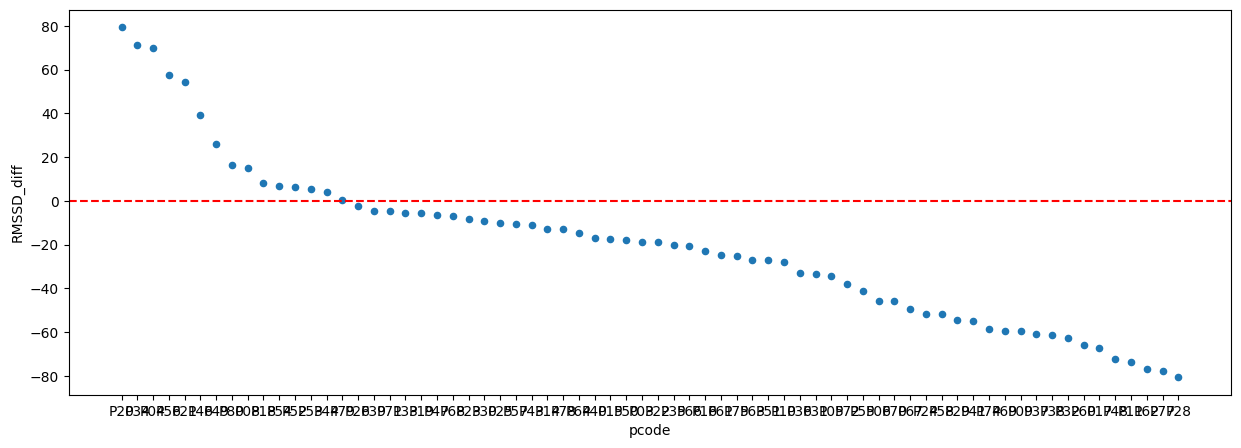

In [104]:

res.sort_values(by=measurement, ascending=False, inplace=True)
# res = res[4:64]
plot = res.plot(x='pcode', y=measurement, kind='scatter', figsize=(15, 5))


plot.axhline(0, color='red', linestyle='--', label='y=0 line')

In [105]:
# res.sort_values(by='CVSD_diff', ascending=False, inplace=True)
# plot = res.plot(x='pcode', y='CVSD_diff', kind='scatter', figsize=(15, 5))
# 
# plot.axhline(0, color='red', linestyle='--', label='y=0 line')
# 
# res.plot(x='pcode', y='RMSSD_diff', kind='scatter', color='orange', label='RMSSD_diff', ax=plot)
# 
# 
# plt.show()

In [106]:
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


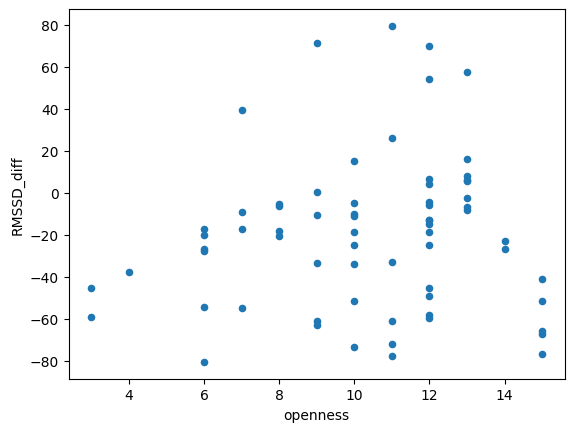

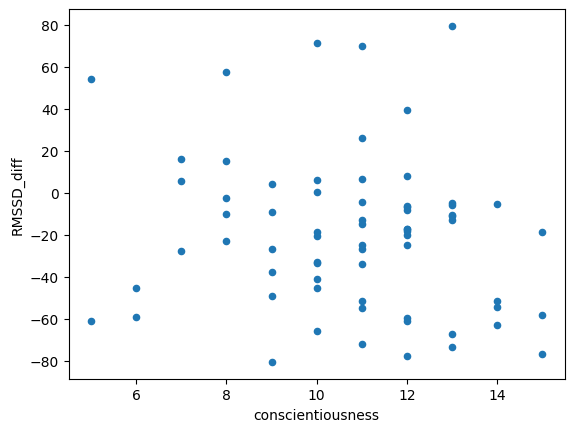

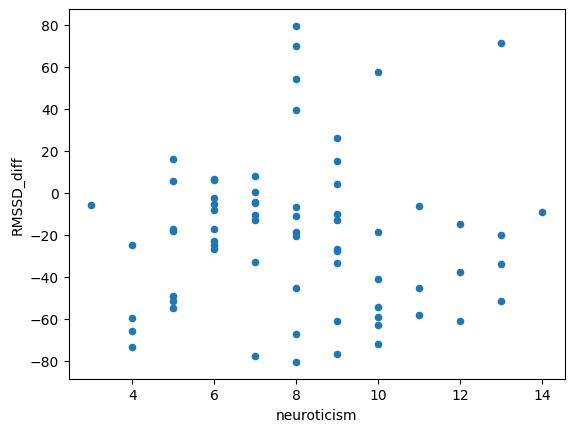

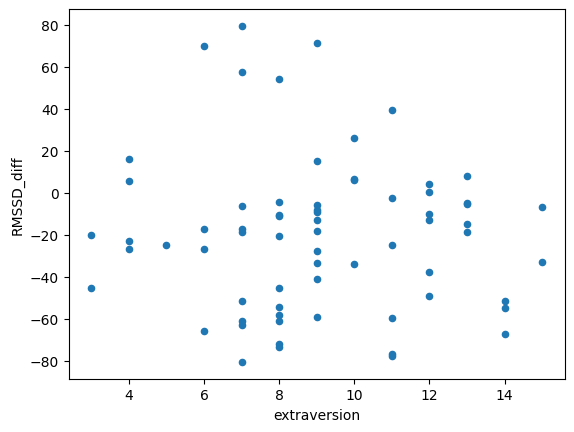

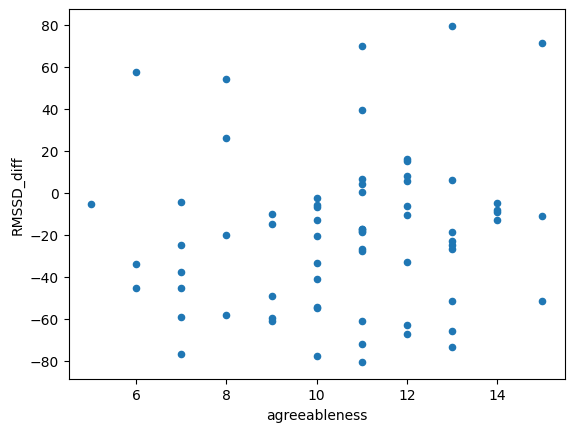

In [107]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

for trait in personality_traits:
    df_test.plot(x=trait, y=measurement, kind='scatter')


In [108]:
import statsmodels.api as sm

X = df_test[personality_traits]
y = df_test[measurement]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             RMSSD_diff   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.8136
Date:                Thu, 30 May 2024   Prob (F-statistic):              0.544
Time:                        15:57:48   Log-Likelihood:                -338.72
No. Observations:                  68   AIC:                             689.4
Df Residuals:                      62   BIC:                             702.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -29.5454     38.40

ShapiroResult(statistic=0.9604064595560629, pvalue=0.029855838924832952)

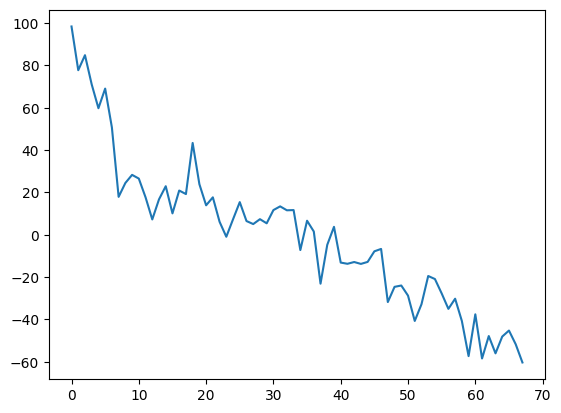

In [109]:
plt.plot(results.resid)
scipy.stats.shapiro(results.resid)

In [110]:
df_corr = df_test[personality_traits + ['CVSD_diff', 'RMSSD_diff']]
print(df_corr.corr(method='pearson'))

                   openness  conscientiousness  neuroticism  extraversion  \
openness           1.000000           0.144790    -0.340042      0.195064   
conscientiousness  0.144790           1.000000    -0.061858      0.159206   
neuroticism       -0.340042          -0.061858     1.000000     -0.065326   
extraversion       0.195064           0.159206    -0.065326      1.000000   
agreeableness      0.170132           0.112717    -0.172050      0.015793   
CVSD_diff          0.113238          -0.178331     0.024125     -0.004970   
RMSSD_diff         0.095328          -0.159016     0.015053     -0.062643   

                   agreeableness  CVSD_diff  RMSSD_diff  
openness                0.170132   0.113238    0.095328  
conscientiousness       0.112717  -0.178331   -0.159016  
neuroticism            -0.172050   0.024125    0.015053  
extraversion            0.015793  -0.004970   -0.062643  
agreeableness           1.000000   0.154042    0.120092  
CVSD_diff               0.154042   